In [53]:
from functools import partial
from numbers import Complex
from typing import Callable

import PIL
import glob
import imageio
import matplotlib.pyplot as plt 
import numpy as np


In [54]:
def douady_hubbard_polynomial(z: Complex,
                              c: Complex) -> Complex:
    """
    Monic and centered quadratic complex polynomial
    https://en.wikipedia.org/wiki/Complex_quadratic_polynomial#Map
    """
    return z ** 2 + c

In [76]:
def julia_set(mapping: Callable[[Complex], Complex], 
            *, 
            min_coordinate: Complex, 
            max_coordinate: Complex, 
            width: int, 
            height: int, 
            iterations_count: int = 256, 
            threshold: float = 2.) -> np.ndarray:
    im, re = np.ogrid[min_coordinate.imag: max_coordinate.imag: height * 1j, min_coordinate.real: max_coordinate.real: width * 1j]

    z = (re + 1j * im).flatten()

    live, = np.indices(z.shape)
    iterations = np.empty_like(z, dtype=int)

    for i in range(iterations_count):
        z_live = z[live] = mapping(z[live])
        escaped = abs(z_live) > threshold
        iterations[live[escaped]] = i
        live = live[~escaped]
        if live.size == 0:
            break
    else: 
        iterations[live] = iterations_count

    return iterations.reshape((height, width))


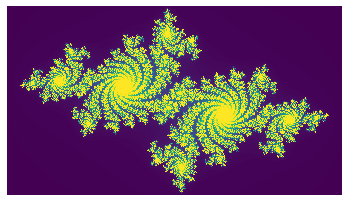

In [78]:
if __name__ == '__main__':
    mapping = partial(douady_hubbard_polynomial, c=-0.7 + 0.27015j)

    image = julia_set(mapping, min_coordinate=-1.6-0.9j, max_coordinate=1.6+0.9j,width=1920, height=1080)

    plt.axis('off')
    plt.imshow(image, cmap='viridis', origin='lower')
    plt.show()

In [57]:
def animator(Gif_out):
    with imageio.get_writer(Gif_out, mode='I') as writer:
        filenames = glob.glob('plot*.png')
        filenames = sorted(filenames)
        last = -1
        for i, filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else: 
                continue
            image = imageio.imread(filename)
            writer.append_data(image)

In [93]:
def generate_images(func, c_1: Complex, step: Complex, iters: int, width, height, min_coord: Complex, max_coord: Complex):
    for i in range(iters):
        mapping = partial(func, c = c_1)

        image = julia_set(mapping, 
                min_coordinate= min_coord, 
                max_coordinate= max_coord, 
                width=width, 
                height=height)
        plt.axis('off')
        plt.imshow(image, cmap='gist_earth')
        plt.savefig('plot_%s.png' % i, dpi=1600)
        c_1 = c_1 + step

In [89]:
def sample_plot(func, c_1: Complex, step: Complex, width, height, min_coord, max_coord):
    
    mapping = partial(func, c = c_1)

    examples = []
    for i in range(16): 
        example = julia_set(mapping, 
        min_coordinate=min_coord, 
        max_coordinate=max_coord,
        width=width,
        height=height)
        examples.append(example)
        c_1 = c_1 + step
    
    fig = plt.figure(figsize=(4,4))
    plt.axis('off')
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.imshow(examples[i], cmap='nipy_spectral_r')
    plt.show()

In [90]:
def tan_func(z: Complex, c: Complex) -> Complex:
    return np.tan(z) ** 3 + c

In [91]:
sample_plot(tan_func, 0.7 - 0.8j, 0.0 + 0.1j,1920,1080,-1.5-1j,1.5+1j)

KeyboardInterrupt: 

In [94]:

generate_images(tan_func, -0.7 + -0.5j, -0.0 + 0.01j, 100,3840,2160,-1.5-1j,1.5+1j)
Gif_out = 'julia_set_tan_func_2.gif'
animator(Gif_out)